In [1]:
import numpy as np
import matplotlib.colors as mcolors
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import cluster
from scipy.spatial import distance
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans, SpectralClustering
import scipy
import time
from collections import Counter, OrderedDict
import math
import warnings
warnings.filterwarnings('ignore')

"Authors : S.Wang, N.Cluzel, M.Courbariaux, G.Nuel"

In [2]:
def log_binomial_coeff(k, n):
    """Computes the log of the binomial coefficient, later on used for eBIC criterion.

    gammaln(n) = np.log(gamma(n)) = np.log(math.factorial(n-1))
    
    """    
    return scipy.special.gammaln(n+1) - scipy.special.gammaln(k+1) - scipy.special.gammaln(n-k+1)
    
def compute_log_prob(X, means, cov_mat, pis):
    """Computes the log-likelihood.

    Parameters
    ----------
    X : array-like, shape=[n_samples, n_dim]
    The data used as an input for the clustering process.
      
    means : array_like, shape=[K, n_dim] where K is the number of clusters.
    The coordinates of centroids.

    cov_mat: array-like, shape=[n_dim, n_dim]
    The covariance matrix, assumed diagonal in this model.

    """  
    
    n_samples, n_dim = X.shape   
    sum_log_prob = 0
    N = len(means)
    sum_prob = 0
    
    for k in range(len(means)):
        sum_prob += pis[k] * (1/(2 * np.pi)**(n_dim/2)) * (1/np.sqrt(np.linalg.det(cov_mat[k]))) * np.exp(-(1/2) * np.dot(np.dot(X - means[k], np.linalg.inv(cov_mat[k])), (X - means[k]).T))

    sum_log_prob = np.sum(np.log((np.diag(sum_prob))))
        
    return np.sum(sum_log_prob)

def compute_BIC(X, means, cov_mat, pis, enhanced=True):
    """Computes the log the BIC criterion.
    If enhanced is set as True, the enhanced BIC will be computed instead.
    
    """  
    n_samples, n_dim = X.shape    
      
    if enhanced==True:
        return -2 * compute_log_prob(X, means, cov_mat, pis) + len(means) * np.log(n_samples) + 2 * log_binomial_coeff(len(means), n_samples)
    else:
        return -2 * compute_log_prob(X, means, cov_mat, pis) + len(means) * np.log(n_samples)

In [3]:
import numpy as np

class EMST():
    
    def __init__(self, X):
        '''
        X: data array
        '''
        self.data = X
        self.nbVertices = X.shape[0]
        
    
    #=============
    # preparation
    #=============
    def getAdjMatrix(self):
        '''
        return the adjacency matrix from the data array
        '''
        self.M = np.zeros((self.nbVertices, self.nbVertices))
        for i in range(self.nbVertices):
            for j in range(i,self.nbVertices):
                self.M[i,j] = np.linalg.norm(self.data[i]-self.data[j])

        self.M += self.M.T
    
    
    #=================
    # helper function
    #=================
    def _minKey(self, key, inMSTSet):
        '''
        find the vertex with minmum distance value, from the complement of the mstSet
        key: array of positive real numbers, key values used to pick minimum weight edge
        inMSTSet: array of booleans, whether an element is in the mstSet
        '''
        m = np.inf
        for v in range(self.nbVertices):
            if (key[v] < m) & (~inMSTSet[v]):
                m = key[v]
                mInd = v
        return mInd
    
    
    #==============================
    # "main" function of the class
    #==============================
    def getEMST(self):
        '''
        construct the MST using Prim's algorithm
        '''
        # key values used to pick the vertex from the complement of mstSet to mstSet
        key = np.ones(self.nbVertices) * np.inf
        key[0] = 0
        
        # elements in the mstSet
        mstSet = np.ones(self.nbVertices) * np.nan
        mstSet[0] = -1
        
        # boolean array indicating whether an element is in mstSet
        inMSTSet = np.zeros(self.nbVertices, dtype=bool)
        
        for _ in range(self.nbVertices):
            u = self._minKey(key, inMSTSet)
            
            # mark the vertex as a node of the MST
            inMSTSet[u] = True 
            
            for v in range(self.nbVertices):
                # update the key if
                #     u and v are adjacent vertices (self.M[u,v] > 0)
                #     v not in mstSet (~inMSTSet[v])
                #     distance between u and v is smaller than key[v] (key[v] > self.M[u,v])
                if (self.M[u,v] > 0) & (~inMSTSet[v]) & (key[v] > self.M[u,v]):
                    key[v] = self.M[u,v]
                    mstSet[v] = u
                 
        self.mst_pair_weight = self._makeMSTDictionary(mstSet)
     
    #=========================
    # formating, finalisation
    #=========================
    def _makeMSTDictionary(self, parent):
        '''
        store the MST in a dictionnary whose keys are pairs of neighbors and 
        whose values are the Euclidian length of the corresponding edge
        
        parent: list of integers, all parent nodes
        '''
        mst = {}
        for i in range(1, self.nbVertices):
            mst[(int(parent[i]), i)] = self.M[i, int(parent[i])]
        return mst
    
    def _transformTree(self, tree=None):
        '''
        create an other dictionary of the EMST whose keys are each node and values are lists of neighbors
        '''
        if tree is None:
            mst_pair_weight = self.mst_pair_weight
        else:
            mst_pair_weight = tree
            
        adjTree = np.zeros_like(self.M)
        for key in mst_pair_weight.keys():
            adjTree[key] = mst_pair_weight[key]
        
        adjTree += adjTree.T 
        
        self.mst_node_neighb = {}
        for i in range(self.M.shape[0]):
            self.mst_node_neighb[i] = np.where(adjTree[i])[0]
           
    

class HEMST():
    def __init__(self, emst):
        self.emst = emst
        self.nbVertices = self.emst.nbVertices
        
        
        
    def cutEdges(self, sig=1):
        '''
        hierarchical EMST clustering algorithm by Grygorash et al.
        sig: strictly positive number, number of standard diviation away from the average edge length 
        that an edge is considered to be cut
        '''
        self.slicedTrees = self.emst.mst_pair_weight.copy()
        
        edgeWeights = np.array(list(self.emst.mst_pair_weight.values()))
        avgDist = edgeWeights.mean()
        stdDist = edgeWeights.std()
        self.nbClusters = 1
        
        toBeRemoved = { key:value for key, value in self.emst.mst_pair_weight.items() if value > avgDist + sig * stdDist }
        self.nbClusters += len(toBeRemoved)
        for key in toBeRemoved.keys():
            del self.slicedTrees[key]
            
    def getComponents(self):
        '''
        get all components of the emst
        '''
        self.visited = np.zeros(self.nbVertices, dtype=bool)
        
        self.emst._transformTree(tree=self.slicedTrees)
        isRoot = np.ones(self.nbVertices, dtype=bool)
        
        # loop through all parent-child tuples, set False in the isRoot list to all child nodes
        for tup in self.slicedTrees.keys():
            isRoot[tup[1]] = False
        
        self.components = [[] for _ in range(self.nbClusters)]
        c = 0
        for i in range(self.nbVertices):
            if isRoot[i]:
                self.getSubTree(i, self.components[c])                
                c += 1
                
        self.labels = np.array([None]*self.nbVertices)      
        for i in range(len(self.components)):
            for node in self.components[i]:
                self.labels[node] = i
                
    def getSubTree(self, root, subTree):
        '''
        Depth first search
        root: integer, index of the starting node
        '''

        # keep track of node visited  
        self.visited[root] = 1 
        subTree.append(root)  

        for iteration in self.emst.mst_node_neighb[root]:  
            if not self.visited[iteration]:
                self.getSubTree(iteration, subTree)
        return
    
    

In [4]:
def plotTree(X, pairWeight):
    '''
    plot 2D trees
    '''
    plt.figure(figsize=(10,10))
    for tup in pairWeight.keys():
        plt.plot([X[tup[0],0],X[tup[1],0]], [X[tup[0],1],X[tup[1],1]], 'co-')
    plt.show()

In [5]:
class EMSTSegmentation():
    """Performs fused adaptive Ridge over a set of points.

    Parameters
    ----------
    X : array-like, shape=[n_samples, n_dim]
    The data used as an input for the clustering process.

    W : array-like, shape=[n_samples, n_samples]
    The sparse matrix of weights related to edges in the EMST.
    This input is only used if warm_start is set as True.

    nodes_dict : dictionnary
    {k, v} as {node, [connected nodes]}.

    lmbda : float
    The Ridge penalization factor.

    delta : float
    The float used for reference to assess if two different clustering centers are similar.

    max_iter : int
    The maximum number of iterations if convergence is not reached before.

    tol : float
    The convergence criterion.

    print_convergence : boolean
    If True, prints additionnal information for each iteration.

    print_specific_computing_times : boolean
    If True, prints the computing times for W, A and mu, for each iteration, in ms.

    warm_start : boolean
    If True, when performing grid-search over a set of lambdas, uses the latest W as 
    a starting point for the following lambda.

    Attributes
    ----------        
    cluster_centers_ : array_like, shape=[K, n_dim] where K is the number of clusters.
    Coordinates of centroids.

    labels_: array-like, shape=[n_samples, 1]
    Labels of each point.

    """        
    def __init__(self, X, W, nodes_dict, lmbda=1.0, delta=1e-5,
                max_iter=500, tol=1e-5, print_convergence=False,
                print_clustering_summary=False, print_specific_computing_times=False,
                warm_start=True):
        self.lmbda = lmbda
        self.delta = delta
        self.max_iter = max_iter
        self.tol = tol
        self.thresh = 0.99
        self.print_convergence = print_convergence
        self.print_clustering_summary = print_clustering_summary
        self.print_specific_computing_times = print_specific_computing_times
        self.mu_history = []
        self.clusters_centers_ = []
        self.groups = {}
        self.valist = []
        self.n_samples, self.n_dim = X.shape
        self.labels_ = np.asarray([None] * self.n_samples)
        self.mu = X.copy()
        self.sigma = []
        self.emission_probas = []
        self.A = np.zeros((self.n_samples, self.n_samples))
        self.W = np.ones((self.n_samples, self.n_samples))
        self.sel = np.ones((self.n_samples, self.n_samples))
        self.labels_history = {}
        self.clusters_centers_history = {}
        
        if warm_start==True:
            self.W = W
     
    def update_mu(self, X):
        """Solves the sparse linear system X=Amu.

        Parameters
        ----------
        X : array-like, shape=[n_samples, n_dim]
        The data used as an input for the clustering process. 

        """
        if self.print_specific_computing_times==True:
            print("Updating mu...")
        time1 = time.time()
        self.mu = scipy.sparse.linalg.spsolve(self.A, X)
        time2 = time.time()
        if self.print_specific_computing_times==True:
            print("Mu updated. Time elapsed : " + str((time2-time1)*1000.0) + "ms.")
        
    def update_W(self):
        """Updates W and sel.
        
        """
        if self.print_specific_computing_times==True:
            print("Updating W...")
        time1 = time.time()
        # Update the weight matrix :
        for i in list(nodes_dict.keys()):
            for j in list(nodes_dict.get(i)):
                self.W[i,j] = 1/((np.linalg.norm(self.mu[i,:]-self.mu[j,:]))**2 + self.delta**2) 
                self.sel[i,j] = self.W[i,j] * (np.linalg.norm(self.mu[i,:]-self.mu[j,:]))**2
        time2 = time.time()
        if self.print_specific_computing_times==True:
            print("W updated. Time elapsed : " + str((time2-time1)*1000.0) + "ms.") 
        
    def update_A(self):
        """Updates A.
        
        """
        if self.print_specific_computing_times==True:
            print("Updating A...")
        time1 = time.time()
        self.A = np.zeros((self.n_samples, self.n_samples))
        for node in list(nodes_dict.keys()):
            sum_W = 0
            for linked_node in list(nodes_dict.get(node)):
                sum_W += self.W[node, linked_node]
                self.A[node, linked_node] += -self.lmbda * self.W[node, linked_node]
                
            self.A[node, node] += 1 + self.lmbda * sum_W
        time2 = time.time()
        if self.print_specific_computing_times==True:
            print("A updated. Time elapsed : " + str((time2-time1)*1000.0) + "ms.")
            
    def update_Pi(self):
        """Updates Pi.
        
        """
        label_dict = OrderedDict(sorted(Counter(self.labels_).items()))
        for key in (list(label_dict.keys())):
            self.emission_probas.append((label_dict.get(key)/self.n_samples))
            
    def update_sigma(self, X):
        """Updates Sigma.
        
        """    
        for key in (list(Counter(self.labels_).keys())): 
            sigms = []
            for dim in range(self.n_dim):
                Xses = X[np.where(self.labels_==key), dim][0]
                nb_samples = Xses.shape[0]
                try:
                    var = (1/(nb_samples-1)) * np.sum((Xses-self.clusters_centers_[key][dim])**2)
                except ZeroDivisionError:
                    var = (1/(nb_samples)) * np.sum((Xses-self.clusters_centers_[key][dim])**2)
                sigms.append(var)
        
            self.sigma.append(np.eye(self.n_dim) * np.diag(sigms))
        
        
    
    def optim_update(self, X):
        """Updates W and mu, then W.
        Parameter
        ----------
        X : array-like, shape=[n_samples, n_dim]
        The data used as an input for the clustering process. 

        """
        # Update the A matrix :
        # For more details about how A is built, please read the attached documentation.
        self.update_A()
        # Update mu :
        self.update_mu(X)
        # Update weights : 
        self.update_W()
    
    def fit(self, X):
        """Iterates until tolerance criteria is reached or max_iter is exceeded.
        Once convergence is reached, plots the data with cluster colors and a convergence plot.
        Parameter
        ----------
        X : array-like, shape=[n_samples, n_dim]
        The data used as an input for the clustering process. 

        """
        if self.print_convergence==True:
            print("Iterating...")
        for i in range(self.max_iter):
            if i==self.max_iter-1:
                print("Did not reach convergence. Returning last mu.")
                break;
            elif i<self.max_iter-1:
                if i==0:
                    if self.print_convergence==True:
                        print("Iteration " + str(i)) 
                    mu_old = self.mu.copy()
                    self.optim_update(X)
                    self.mu_history.append(np.max((np.abs(self.mu-mu_old)) / (np.abs(mu_old))))
                    if self.print_convergence==True:
                        print(np.max((np.abs(self.mu-mu_old)) / (np.abs(mu_old))))
                elif i>0:
                    if self.print_convergence==True:
                        print("Iteration " + str(i))
                    if np.max((np.abs(self.mu-mu_old)) / (np.abs(mu_old))) < self.tol:
                        #if self.print_convergence==True:
                        print("Convergence reached in " + str(i) +" iterations.")
                        break;
                    else:
                        mu_old = self.mu.copy()
                        self.optim_update(X)
                        self.mu_history.append(np.max((np.abs(self.mu-mu_old)) / (np.abs(mu_old))))
                        if self.print_convergence==True:
                            print(np.max((np.abs(self.mu-mu_old)) / (np.abs(mu_old))))
                            
        # Dict of groups as in key is a node and corresponding value is a list of nodes fused with it.
        # Two nodes are linked by an edge if their relative mus are highly similar. 
        # If the difference between their respective mus exceeds a threshold, their edge is cut.
        # When convergence is reached, the nodes that are still linked by edges belong to the same cluster.
        for i in range(self.n_samples):
            self.groups[i] = np.where(self.sel[i,:]<self.thresh)

        # Merges the groups of nodes with common elements :
        for key, value in (self.groups.items()):
            temp_list = list(value[0])
            temp_list.append(key)
            self.valist.append(tuple(temp_list))
        self.valist = self.merge_tuples(list(set(self.valist)))
        print(str(len(self.valist)) + " clusters found.")

        # Computes labels :
        for i, cluster in enumerate(self.valist):
            self.clusters_centers_.append(self.mu[cluster[0]])
            for value in cluster:
                self.labels_[value] = i 
                
        self.labels_history[self.lmbda] = self.labels_
        self.clusters_centers_history[self.lmbda] = self.clusters_centers_
        
        # Updates estimations of Pi and Covariance matrixes :
        self.update_Pi()
        self.update_sigma(X)

        return self
                            
    def plot_history(self):
        """Plots the convergence curve.
        
        """
        plt.figure(figsize=(16,10))
        plt.plot(self.mu_history, 'r')
        plt.title('Convergence history')
        plt.xlabel('Iteration')
        plt.ylabel('max(|mu-mu_old|/|mu_old|)')
        plt.grid()
        plt.show()
        
    def plot_clusters(self, X):
        """Regroups and plots the clusters.
        
        Parameters
        ----------
        X : array-like, shape=[n_samples, n_dim]
        The data used as an input for the clustering process. 
        
        """   
        toplot = X.copy()
        if X.shape[1]>2:
            std = StandardScaler()
            X_std = std.fit_transform(X)
            seed = 2019
            tsne = TSNE(perplexity=30, learning_rate=500, random_state=seed)
            X_tsne = tsne.fit_transform(X_std)
            toplot = X_tsne
        
        # Defines the bank of colors used later on :
        colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
        colorz = list(colors.keys())
            
        # Plots the different samples with a color respective to their cluster :
        plt.figure(figsize=(16,10))
        for i, cluster in enumerate(self.valist):
            color = np.random.choice(list(mcolors.CSS4_COLORS.keys()))
            if self.print_clustering_summary==True:
                print("Cluster " + str(i))
                print("-------")
                print(cluster)
            for value in cluster:
                plt.plot(toplot[value,0], toplot[value,1], 'o', c=color, label='Cluster ' + str(i))
                
        handles, labels = plt.gca().get_legend_handles_labels()
        labels, ids = np.unique(labels, return_index=True)
        handles = [handles[i] for i in ids]
        plt.legend(handles, labels, loc='best')
        plt.title('Clustering results in proximity space')
        plt.xlabel('X_0')
        plt.ylabel('X_1')
        plt.grid()
        plt.show()   
        
    def merge_tuples(self, tuple_list):        
        """Fuses the lists of common nodes.
        
        Parameters
        ----------
        tuple_list : list
        The list of tuples that we want to get merged. 
        
        """
        # Converts the input list as a set of sets
        iset = set([frozenset(s) for s in tuple_list])  
        result = []
        while(iset):                  
            nset = set(iset.pop())      
            check = len(iset)           
            while check:                
                check = False
                for s in iset.copy():       
                    if nset.intersection(s):  
                        check = True           
                        iset.remove(s)          
                        nset.update(s)          
            result.append(tuple(nset)) 

        return result
    
def plot_clustering_results(X, labels):
    
    # Defines the bank of colors used later on :
    colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
    colorz = list(colors.keys())
    colorz2 = colorz.copy()
    
    diff = len(list(Counter(labels).keys()))-len(colorz)
    
    if diff>0:
        for k in range(diff):
            colorz.append(np.random.choice(colorz))
    
    toplot = X.copy()
    toplot0 = 'X_0'
    toplot1 = 'X_1'
    if X.shape[1]>2:
        std = StandardScaler()
        X_std = std.fit_transform(X)
        seed = 2019
        tsne = TSNE(perplexity=30, learning_rate=500, random_state=seed)
        X_tsne = tsne.fit_transform(X_std)
        toplot = X_tsne
        toplot0 = 'X_tsne_0'
        toplot1 = 'X_tsne_1'
    
    fig, ax = plt.subplots(figsize=(16,10))
    scatter = ax.scatter(toplot[:,0], toplot[:,1], c=[colorz[i] for i in labels]) #cmap=[colorz[i] for i in labels])
    plt.xlabel(toplot0)
    plt.ylabel(toplot1)
    plt.title('Clustering results in proximity space - ' + str(len(list(Counter(labels).keys()))) + ' clusters found.')
    plt.grid()
    plt.show()

In [6]:
X1 = np.random.multivariate_normal([3, 5], np.eye(2) * np.diag([5,3]), 300)
X2 = np.random.multivariate_normal([-5, -2], np.eye(2) * np.diag([5,3]), 100)
X3 = np.random.multivariate_normal([5, 15], np.eye(2) * np.diag([5,3]), 40)
X4 = np.random.multivariate_normal([-19, -2], np.eye(2) * np.diag([5,3]), 50)
X5 = np.random.multivariate_normal([-13, 6], np.eye(2) * np.diag([5,3]), 100)

X = np.vstack((X1, X2, X3, X4, X5))

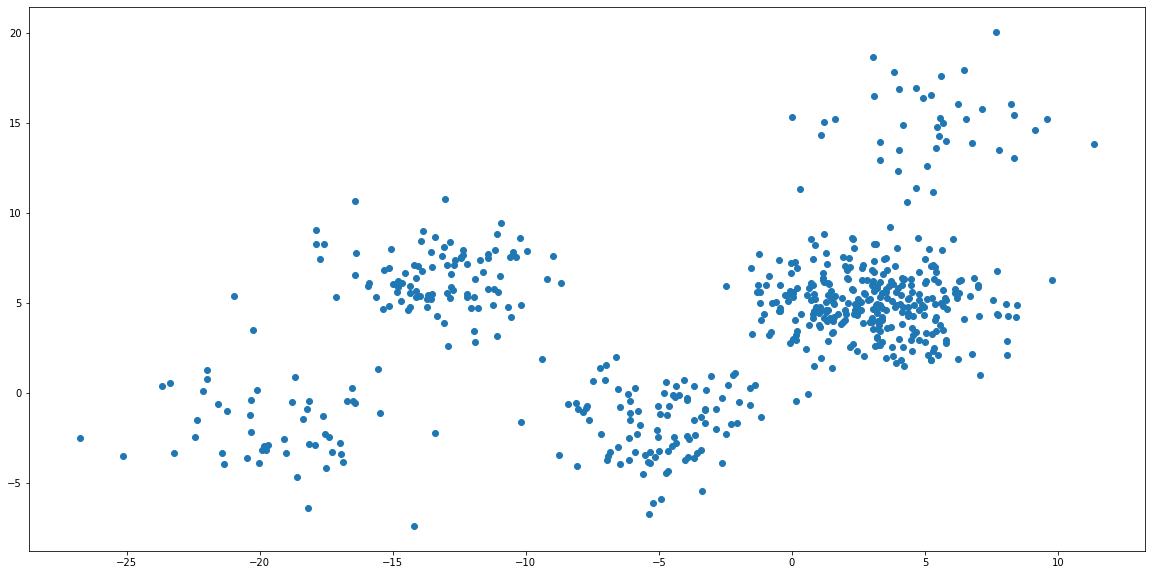

In [7]:
X_ = X.copy()
std = StandardScaler()
X_std = std.fit_transform(X_)

plt.figure(figsize=(20,10))
plt.plot(X_[:,0], X_[:,1], 'o')
plt.show()

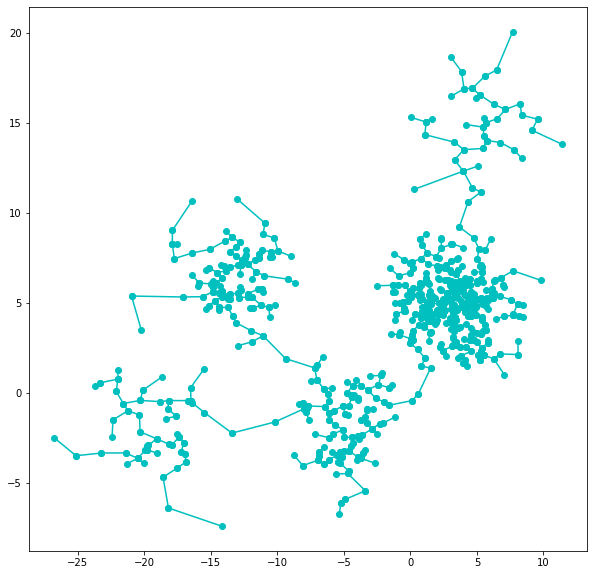

In [8]:
# initialise a EMST class instance
emst = EMST(X_std)

# 1. get the adjacency matrix from the data array
emst.getAdjMatrix()

# 2. then get the Euclidean minimum spanning tree
emst.getEMST()

# 3. convert the tree in dictionnary format
emst._transformTree()
nodes_dict = emst.mst_node_neighb

# 4. (optional) plot the minimum spanning tree
plotTree(X_,emst.mst_pair_weight)

In [16]:
lambdas = np.logspace(-4, 4, 40)
silhouette = {}
bic = {}
noenh_bic = {}
n_clusters = {}
mu_1 = np.asarray([None] * X_.shape[0])
mu_2 = np.asarray([None] * X_.shape[0])
tol = 1e-4
warm_start = True
print_convergence = False
plot_history = False
store_history = True
labels_history = {}
clusters_centers_history = {}
labels_by_best_BIC = []
clusters_centers_by_best_BIC = []
sigmas = []

for i, lmbda in enumerate(lambdas):
    print("Lambda=" +str(lmbda))
    if i==0:
        e_ = EMSTSegmentation(X_, None, nodes_dict, lmbda=lmbda, tol=tol, print_convergence=print_convergence, print_clustering_summary=False, warm_start=False)
    elif i>0:
        e_ = EMSTSegmentation(X_, previous_weights, nodes_dict, lmbda=lmbda, tol=tol, print_convergence=print_convergence, print_clustering_summary=False, warm_start=warm_start)    
    e_.fit(X_)
    if plot_history==True:
        e_.plot_history()
    previous_weights = e_.W.copy()
    previous_mus = e_.mu.copy()
    mu_1 = np.vstack((mu_1,previous_mus[:,0]))
    mu_2 = np.vstack((mu_2,previous_mus[:,1]))
    current_BIC = compute_BIC(X_, e_.clusters_centers_, e_.sigma, e_.emission_probas)
    bic[lmbda] = current_BIC
    noenh_bic[lmbda] = compute_BIC(X_, e_.clusters_centers_, e_.sigma, e_.emission_probas, enhanced=False)
    n_clusters[lmbda] = len(e_.clusters_centers_)
    sigmas.append(e_.sigma)
    if store_history==True:
        labels_history[lmbda] = e_.labels_
        clusters_centers_history[lmbda] = e_.clusters_centers_
    min_BIC = np.min(np.asarray(list(bic.values())))
    if current_BIC<=min_BIC:
        labels_by_best_BIC = e_.labels_
        clusters_centers_by_best_BIC = e_.clusters_centers_
    if (len(Counter(e_.labels_).keys()) > 1) and(len(Counter(e_.labels_).keys()) < X_.shape[0]):
        silhouette[lmbda] = silhouette_score(X_, e_.labels_)

    else:
        print("Only one label detected. Silhouette score can't be computed for this penalty and will be set as -2.")
        silhouette[lmbda] = -2

Lambda=0.0001
Convergence reached in 15 iterations.
587 clusters found.
Lambda=0.0001603718743751331
Convergence reached in 4 iterations.
587 clusters found.
Lambda=0.00025719138090593444
Convergence reached in 14 iterations.
583 clusters found.
Lambda=0.0004124626382901352
Convergence reached in 18 iterations.
580 clusters found.
Lambda=0.0006614740641230146
Convergence reached in 17 iterations.
576 clusters found.
Lambda=0.0010608183551394483
Convergence reached in 28 iterations.
570 clusters found.
Lambda=0.0017012542798525892
Convergence reached in 37 iterations.
559 clusters found.
Lambda=0.0027283333764867696
Convergence reached in 46 iterations.
537 clusters found.
Lambda=0.004375479375074184
Convergence reached in 35 iterations.
511 clusters found.
Lambda=0.007017038286703823
Convergence reached in 43 iterations.
484 clusters found.
Lambda=0.011253355826007646
Convergence reached in 80 iterations.
445 clusters found.
Lambda=0.018047217668271703
Convergence reached in 75 iterati

In [17]:
sigmas

[[array([[7.94281754e-12, 0.00000000e+00],
         [0.00000000e+00, 4.45824444e-08]]),
  array([[5.37991600e-07, 0.00000000e+00],
         [0.00000000e+00, 7.18764114e-08]]),
  array([[6.42977837e-07, 0.00000000e+00],
         [0.00000000e+00, 1.36256119e-08]]),
  array([[7.35941706e-09, 0.00000000e+00],
         [0.00000000e+00, 2.93245468e-09]]),
  array([[3.47459014e-07, 0.00000000e+00],
         [0.00000000e+00, 7.12044063e-09]]),
  array([[9.72307689e-07, 0.00000000e+00],
         [0.00000000e+00, 2.37585693e-06]]),
  array([[2.03123781e-08, 0.00000000e+00],
         [0.00000000e+00, 1.91717840e-08]]),
  array([[7.73840545e-08, 0.00000000e+00],
         [0.00000000e+00, 9.40551599e-11]]),
  array([[9.22270153e-08, 0.00000000e+00],
         [0.00000000e+00, 1.41577095e-08]]),
  array([[1.70028970e-07, 0.00000000e+00],
         [0.00000000e+00, 1.49191096e-07]]),
  array([[4.39082332e-09, 0.00000000e+00],
         [0.00000000e+00, 1.63559550e-06]]),
  array([[8.22258509e-15, 0.0000

In [18]:
bic

{0.0001: inf,
 0.0001603718743751331: inf,
 0.00025719138090593444: inf,
 0.0004124626382901352: inf,
 0.0006614740641230146: inf,
 0.0010608183551394483: inf,
 0.0017012542798525892: inf,
 0.0027283333764867696: inf,
 0.004375479375074184: inf,
 0.007017038286703823: inf,
 0.011253355826007646: 21578.251455634167,
 0.018047217668271703: 15796.956410393179,
 0.028942661247167517: 15255.793133758505,
 0.046415888336127774: 11914.22392417758,
 0.07443803013251689: 10767.706720385695,
 0.11937766417144358: 9785.458994228822,
 0.19144819761699575: 8908.82559693495,
 0.30702906297578497: 8453.568627460698,
 0.49238826317067363: 8151.178509218349,
 0.7896522868499725: 7976.088720866208,
 1.2663801734674023: 7658.036287694558,
 2.030917620904735: 7613.740684590355,
 3.257020655659783: 7405.019597282195,
 5.2233450742668435: 7193.605138700306,
 8.376776400682925: 7115.974147623542,
 13.433993325988988: 7071.964589945115,
 21.54434690031882: 6933.895137600417,
 34.55107294592218: 6893.165650936

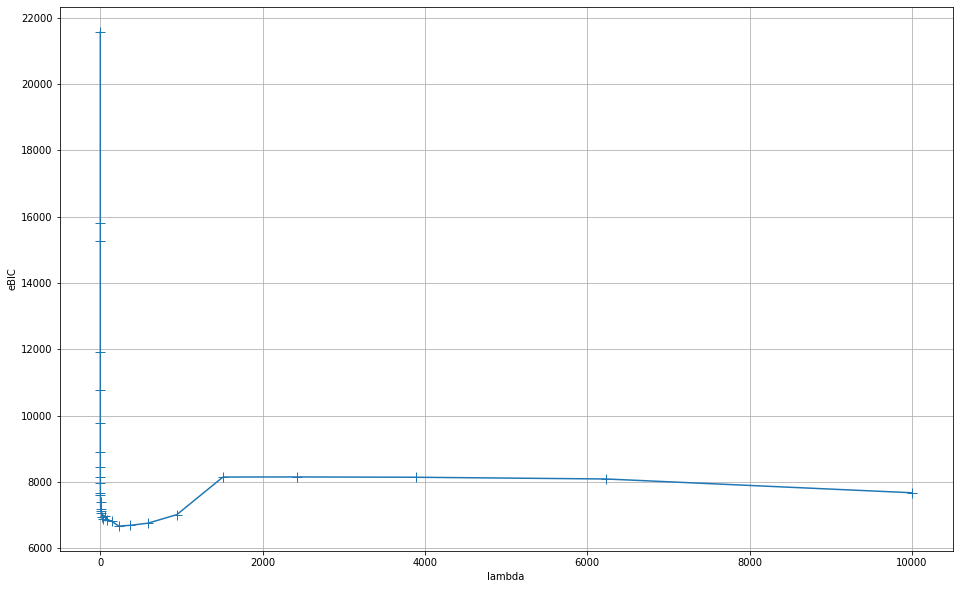

In [13]:
plt.figure(figsize=(16,10))
plt.plot(list(bic.keys()), list(bic.values()), '+-', markersize=10)
#plt.plot(list(noenh_bic.keys()), list(noenh_bic.values()), '+-', markersize=10, color='red')
plt.grid()
plt.xlabel('lambda')
plt.ylabel('eBIC')
plt.show()

Best clustering results according to eBIC :


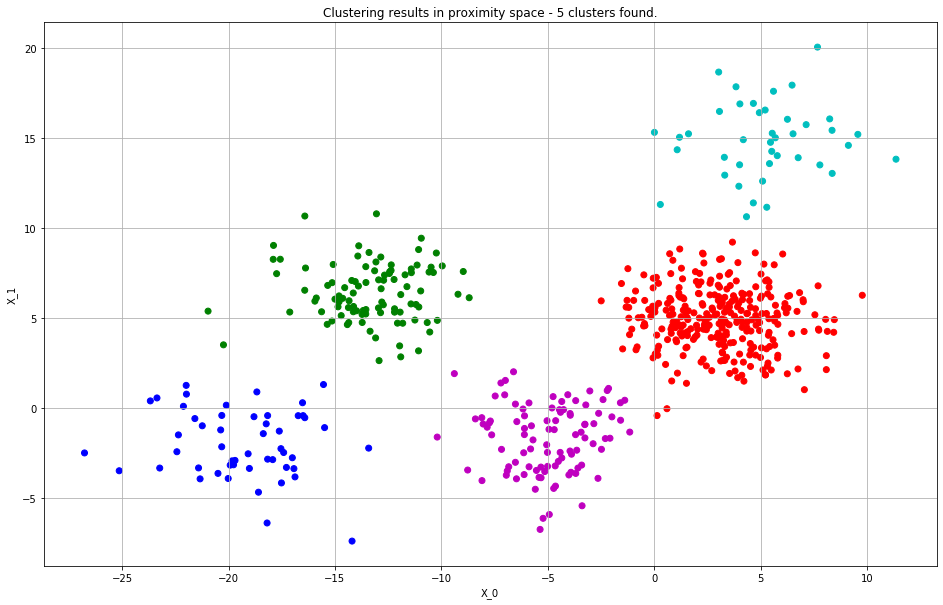

In [14]:
print("Best clustering results according to eBIC :")
best_lbda = lambdas[np.argmin(np.asarray(list(bic.values())))]
plot_clustering_results(X_, labels_by_best_BIC)

In [12]:
mu_1 = mu_1.T
mu_2 = mu_2.T

mu_1 = mu_1[:,1:]
mu_2 = mu_2[:,1:]

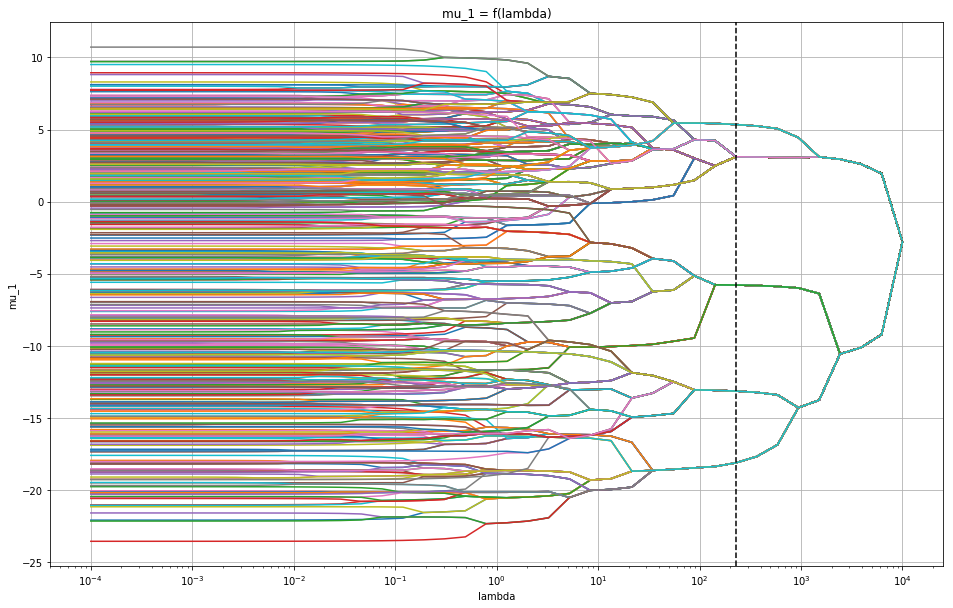

In [13]:
plt.figure(figsize=(16,10))
for k in range(mu_1.shape[0]):
    plt.plot(lambdas, mu_1[k])
plt.title('mu_1 = f(lambda)')
plt.grid()
plt.xlabel('lambda')
plt.ylabel('mu_1')
plt.xscale('log')
plt.axvline(lambdas[np.argmin(np.asarray(list(bic.values())))], ls='--',color='black')
plt.show()

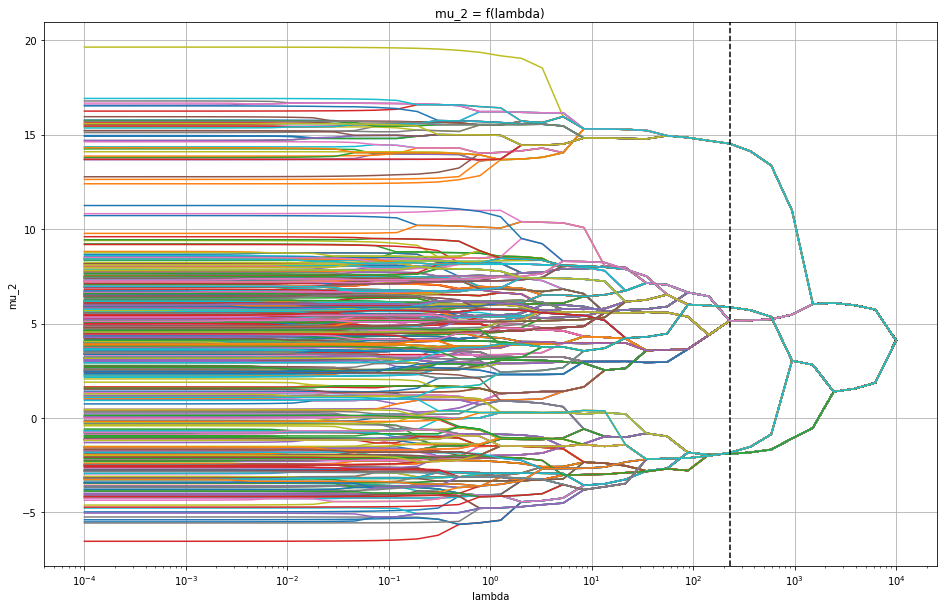

In [14]:
plt.figure(figsize=(16,10))
for k in range(mu_2.shape[0]):
    plt.plot(lambdas, mu_2[k])
plt.title('mu_2 = f(lambda)')
plt.grid()
plt.xlabel('lambda')
plt.ylabel('mu_2')
plt.xscale('log')
plt.axvline(lambdas[np.argmin(np.asarray(list(bic.values())))], ls='--',color='black')
plt.show()